In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import torch
import random

from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import TensorDataset
import copy
import gym_minigrid
from soccer_env import soccer
import cvxpy as cp

# ce_q learning

In [61]:
def get_v(q_a,q_b,a_loc,b_loc,has_ball,done,verbose):
    #establish the matrix similar to hw6 input reward matrix for all players, which will be 5*5
    if done: 
        v_a = 0
        v_b = 0
        return v_a,v_b
    else:
        r_a = q_a[a_loc,b_loc,has_ball]
        r_b = q_b[a_loc,b_loc,has_ball].T
        constraints = []
        #print(r)
        # row player is A column player is B
        pa = cp.Variable((5,5)) 
        constraints = []
        #constraints regarding equilibrium
        for a in range(5):
            q_diff = np.empty([5,0])
            for i in range(5):
                if (a!=i):
                    q_diff = np.append(q_diff,np.array([r_a[a,:]-r_a[i,:]]).T,axis = 1)
                #print(q_diff)
            lhs = pa[a,:]@q_diff
            #print(lhs)
            constraints = constraints + [lhs>=0]
        pb = pa.T
        for b in range(5):
            q_diff = np.empty([5,0])
            for i in range(5):
                if (b!=i):
                    q_diff = np.append(q_diff,np.array([r_b[b,:]-r_b[i,:]]).T,axis = 1)
                #print(q_diff)
            lhs = pb[b,:]@q_diff
            #print(lhs)
            constraints = constraints + [lhs>=0]
        #constraints around pa itself
        #np.full([5,5],0.000000000000001)
        constraints = constraints + [pa >= 0]
        constraints = constraints + [cp.sum(pa) == 1]
        #constraints: CEQ has 5*4*2 + 25 + 1 constraints and one objective. maximize(p*(q1 + q2))
        # utilitarian ce q objective: maximize combined expected values
        objective = cp.Maximize(cp.sum(cp.multiply(pa,r_a)+cp.multiply(pb,r_b)))
        problem = cp.Problem(objective,constraints)
        #solver='ECOS_BB'
        result = problem.solve()
        p = pa.value
        p[p<= 1e-5] = 0
        #normalise p
        p = p/np.sum(p)
        #print('p',p)
        v_a =  np.sum(np.multiply(p,r_a))
        v_b = np.sum(np.multiply(p.T,r_b)) 
        if(verbose):
            print('p is:',p)
            print('r_a is:',r_a)
            print('v_a is:',v_a)
        #print('v_a',v_a)
        return v_a, v_b

In [ ]:
env = soccer()
env.reset()
n_steps = 1000000
step = 0
epsilon = 1
gamma = 0.9
q_a = np.zeros((8,8,2,len(env.action_space()),len(env.action_space())))
q_b = np.zeros((8,8,2,len(env.action_space()),len(env.action_space())))
errors = np.empty(shape=[0, 2])
alpha = 1
alpha_decay_rate = 0.999993
#epsilon_decay_rate = 0.999995
done = False
a_loc,b_loc,has_ball = env.reset()
for _ in range(n_steps):
    step+=1
    if(step%1000 == 0):print('step:', step)
    #loop for each step of step
    if(done): 
        a_loc,b_loc,has_ball = env.reset()
        #print('finishing one episode')
        done = False
    #Choose actions from S randomly 
    a_a = env.sample_action()
    a_b = env.sample_action()
    a_loc_next, b_loc_next,has_ball_next,a_reward,b_reward,done = env.step(a_a,a_b)
    #print(a_loc_next, b_loc_next,has_ball_next,a_reward,b_reward,done)
    #solve for minimax based on current states and get v
    if a_loc == 2 and b_loc == 1 and has_ball == 1 and a_a == 1 and a_b == 4:
        verbose = False
    else: verbose = False
    v_a,v_b = get_v(q_a,q_b,a_loc_next,b_loc_next,has_ball_next,done,verbose = verbose)
    #print('v value is:',v)
    #update q value
    q_update_a = alpha*((1-gamma)*(a_reward)+gamma*v_a)
    new_q_a = (1-alpha)*q_a[a_loc,b_loc,has_ball,a_a,a_b]+q_update_a
    #print('v_a',v_a)
    #print('new_q_a:',new_q_a)
    q_update_b = alpha*((1-gamma)*(b_reward)+gamma*v_b)
    new_q_b = (1-alpha)*q_b[a_loc,b_loc,has_ball,a_a,a_b]+q_update_b
##### debugging prints
#     print('q_update_a:',q_update_a)
#     print('new_q_a:',new_q_a)
#     print('old_q_a:',q_a[a_loc,b_loc,has_ball,a_a,a_b])
    #document error when in state s and A taking action S and b sticking
    if a_loc == 2 and b_loc == 1 and has_ball == 1 and a_a == 1 and a_b == 4: 
#         print('v_a',v_a)
#         print('q_update_a:',q_update_a)
#         print('new_q_a:',new_q_a)
#         print('old_q_a:',q_a[2,1,1,1,4])
        error = abs(new_q_a-q_a[2,1,1,1,4])
        errors = np.append(errors,np.array([[step-1,error]]),axis=0)
        print(errors)
    q_a[a_loc,b_loc,has_ball,a_a,a_b] = new_q_a
    q_b[a_loc,b_loc,has_ball,a_a,a_b] = new_q_b
    #update states
    a_loc = a_loc_next
    b_loc = b_loc_next
    has_ball = has_ball_next
    alpha = alpha*alpha_decay_rate

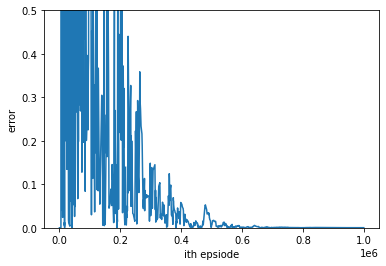

In [65]:
#plot the errors
plt.plot(errors[:,0],errors[:,1])
plt.ylabel('error')
plt.xlabel('ith epsiode')
plt.ylim(0,0.5)
plt.show()